In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Load the Data to Be Tested on the Trained Model

In [2]:
Xtest = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_10_resized.npy')
Ytest = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_10_resized.npy')

ModelName1 = 'Kmeans'
ModelName2 = 'MeanShift'

In [ ]:
print(Xtest.shape)

(888, 128, 128, 3)


##Make Unsupervised Predictions on the Given Dataset and Get Stats

In [ ]:
def AssignLabels(mask, image): # for matching up labels after unsupervised segmentation 

    NewMask = mask
    Index0 = np.where(mask == 0)
    Index1 = np.where(mask == 1)
    Index2 = np.where(mask == 2)
    Index3 = np.where(mask == 3)

    IndxGroups = [Index0, Index1, Index2, Index3]

    AvgVal0 = np.mean(image[Index0])
    AvgVal1 = np.mean(image[Index1])
    AvgVal2 = np.mean(image[Index2])
    AvgVal3 = np.mean(image[Index3])

    Class1 = np.argmin([AvgVal0, AvgVal1, AvgVal2, AvgVal3]) #lowest average value in real image = most likely sky 
    NewMask[IndxGroups[Class1]] = 1 # make the segmented sky part correspond to class 1 
    NewMask[IndxGroups[1]] = Class1 # swap the labels

    #next, of the remaining labels, find those of the largest class = most likely ground
    Index0 = np.where(NewMask == 0)
    Index1 = np.where(NewMask == 1)
    Index2 = np.where(NewMask == 2)
    Index3 = np.where(NewMask == 3)

    IndxGroups = [Index0, Index1, Index2, Index3]
    IndxGroupsSum = [np.sum(k) for k in IndxGroups]
    IndxGroupsSum[1] = -1 # set to -1 to prevent sky label from being chosen 
    Class0 = np.argmax(IndxGroupsSum)
    NewMask[IndxGroups[Class0]] = 0
    NewMask[IndxGroups[0]] = Class0

    return NewMask

Computing Rand Error and Structural Similiarity Index

In [ ]:
from skimage.metrics import adapted_rand_error
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

N_clusters = 4 # number of classes = number of clusters

#Total Error
AverageRandError = [0,0]
AverageSSI = [0,0]
AverageMSE = [0,0]
AverageNMI = [0,0]
#variance
VarSSIKmeans = []
VarRandKmeans = []
VarMSEKmeans = []
VarNMIKmeans = []

VarSSIMeanShift = []
VarRandMeanShift = []
VarMSEMeanShift = []
VarNMIMeanShift = []

Yhat_storageKmeans = np.zeros(Ytest.shape) #initialize Yhat 
Ytrue_storageKmeans = np.zeros(Ytest.shape)
Yhat_storageMeanShift = np.zeros(Ytest.shape) #initialize Yhat 
Ytrue_storageMeanShift = np.zeros(Ytest.shape)

#estimate bandwidth
j = 5
bw_point = Xtest[j,:,:,0]
bw_point = Xtest[j,:,:,0]
bw_point = np.squeeze(bw_point)
bw_point = bw_point.reshape((bw_point.shape[0]* bw_point.shape[1],1))
bandwidth = estimate_bandwidth(bw_point)

NumSamples = 300 #Xtest.shape[0]
for k in range(0,NumSamples): #): # iterate through the test set
  print(k, '\n')

  #modify the data to be the proper shape for K-Means clustering
  sample_point = Xtest[k,:,:,0]
  sample_label = Ytest[k,:,:,:]
  sample_label = sample_label.astype(int)
  sample_point = np.squeeze(sample_point)
  sample_point = sample_point.reshape((sample_point.shape[0]* sample_point.shape[1],1))
  #sample_label = np.squeeze(sample_label)


#Unsupervised Model Predictions
  YhatKmeans = KMeans(N_clusters, init='k-means++', random_state = 0).fit(sample_point) # Kmeans cluster prediction
  Yhat_maskKmeans = YhatKmeans.labels_.reshape(Xtest.shape[1], Xtest.shape[2])
  Yhat_maskKmeans = AssignLabels(Yhat_maskKmeans, Xtest[k,:,:,0])

  
  MeanShiftCluster = MeanShift(bandwidth = bandwidth).fit(sample_point) #Mean Shift algorithm
  Yhat_maskMeanShift = MeanShiftCluster.labels_.reshape(Xtest.shape[1], Xtest.shape[2])

#Statistics Calculations
  #convert to proper mask labels for relevant stats
  Yhat_maskKmeans = Yhat_maskKmeans[..., tf.newaxis]
  Yhat_maskMeanShift = Yhat_maskMeanShift[..., tf.newaxis]


  #store Yhat for computing pixel by pixel statistics
  Yhat_storageKmeans[k,:,:,:] = Yhat_maskKmeans
  Ytrue_storageKmeans[k,:,:,:] = sample_label # store true labels here in proper format for easier stat generation
  
  Yhat_storageMeanShift[k,:,:,:] = Yhat_maskMeanShift
  Ytrue_storageMeanShift[k,:,:,:] = sample_label # store true labels here in proper format for easier stat generation

  #include class 0 in the statistics (skimage module automatically ignores class 0 by default)
  sample_label += 1
  Yhat_maskKmeans += 1
  Yhat_maskMeanShift += 1

  #Rand Error
  Error = adapted_rand_error(sample_label, Yhat_maskKmeans)
  AverageRandError[0] += Error[0]
  VarRandKmeans.append(Error)

  Error = adapted_rand_error(sample_label, Yhat_maskMeanShift)
  AverageRandError[1] += Error[0]
  VarRandMeanShift.append(Error)

  #SSI
  ssi = structural_similarity(sample_label, Yhat_maskKmeans, multichannel=True, data_range=4, gaussian_weights = True)
  AverageSSI[0] += ssi
  VarSSIKmeans.append(ssi)

  ssi = structural_similarity(sample_label, Yhat_maskMeanShift, multichannel=True, data_range=4, gaussian_weights = True)
  AverageSSI[1] += ssi
  VarSSIMeanShift.append(ssi)


  #MSE 
  mse = mean_squared_error(np.ravel(sample_label), np.ravel(Yhat_maskKmeans))
  AverageMSE[0] += mse
  VarMSEKmeans.append(mse)

  mse = mean_squared_error(np.ravel(sample_label), np.ravel(Yhat_maskMeanShift))
  AverageMSE[1] += mse
  VarMSEMeanShift.append(mse)

  #Normalized Mutual Information
  nmi = normalized_mutual_info_score(np.ravel(sample_label), np.ravel(Yhat_maskKmeans))
  AverageNMI[0] += nmi
  VarNMIKmeans.append(nmi)

  nmi = normalized_mutual_info_score(np.ravel(sample_label), np.ravel(Yhat_maskMeanShift))
  AverageNMI[1] += nmi
  VarNMIMeanShift.append(nmi)

print('K MEANS')
AverageRandError[0] = AverageRandError[0] / NumSamples
VarRandKmeans = np.var(VarRandKmeans)
print('The Average Adapted Rand Error Kmeans is:', AverageRandError)
print('Variance of Adapted Rand Error Kmeans is:', VarRandKmeans)

AverageSSI[0] = AverageSSI[0] / NumSamples
VarSSIKmeans = np.var(VarSSIKmeans)
print('The Average SSI Kmeans is:', AverageSSI)
print('Variance of SSI Kmeans is:', VarSSIKmeans)

AverageMSE[0] = AverageMSE[0] / NumSamples
VarMSEKmeans = np.var(VarMSEKmeans)
print('The Average MSE Kmeans is:', AverageMSE)
print('Variance of MSE Kmeans is:', VarMSEKmeans)

AverageNMI[0] = AverageNMI[0] /NumSamples
VarNMIKmeans = np.var(VarNMIKmeans)
print('The Average NMI Kmeans is:', AverageNMI)
print('Variance of NMI Kmeans is:', VarNMIKmeans)
print('\n\n\n')

print('Mean Shift')
AverageRandError[1] = AverageRandError[1] / NumSamples
VarRandMeanShift = np.var(VarRandMeanShift)
print('The Average Adapted Rand Error MeanShift is:', AverageRandError)
print('Variance of Adapted Rand Error MeanShift is:', VarRandMeanShift)

AverageSSI[1] = AverageSSI[1] / NumSamples
VarSSIMeanShift = np.var(VarSSIMeanShift)
print('The Average SSI MeanShift is:', AverageSSI)
print('Variance of SSI MeanShift is:', VarSSIMeanShift)

AverageMSE[1] = AverageMSE[1] / NumSamples
VarMSEMeanShift = np.var(VarMSEMeanShift)
print('The Average MSE MeanShift is:', AverageMSE)
print('Variance of MSE MeanShift is:', VarMSEMeanShift)

AverageNMI[1] = AverageNMI[1] / NumSamples
VarNMIMeanShift = np.var(VarNMIMeanShift)
print('The Average NMI MeanShift is:', AverageNMI)
print('Variance of NMI MeanShift is:', VarNMIMeanShift)
print('\n\n\n')


0 

1 

2 

3 

4 

5 

6 

7 

8 

9 

10 

11 

12 

13 

14 

15 

16 

17 

18 

19 

20 

21 

22 

23 

24 

25 

26 

27 

28 

29 

30 

31 

32 

33 

34 

35 

36 

37 

38 

39 

40 

41 

42 

43 

44 

45 

46 

47 

48 

49 

50 

51 

52 

53 

54 

55 

56 

57 

58 

59 

60 

61 

62 

63 

64 

65 

66 

67 

68 

69 

70 

71 

72 

73 

74 

75 

76 

77 

78 

79 

80 

81 

82 

83 

84 

85 

86 

87 

88 

89 

90 

91 

92 

93 

94 

95 

96 

97 

98 

99 

100 

101 

102 

103 

104 

105 

106 

107 

108 

109 

110 

111 

112 

113 

114 

115 

116 

117 

118 

119 

120 

121 

122 

123 

124 

125 

126 

127 

128 

129 

130 

131 

132 

133 

134 

135 

136 

137 

138 

139 

140 

141 

142 

143 

144 

145 

146 

147 

148 

149 

150 

151 

152 

153 

154 

155 

156 

157 

158 

159 

160 

161 

162 

163 

164 

165 

166 

167 

168 

169 

170 

171 

172 

173 

174 

175 

176 

177 

178 

179 

180 

181 

182 

183 

184 



## Compute Pure Pixel Error and Statistics on Pixel by Pixel Basis 

In [ ]:
## classification report
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

#vectorize image data - Kmeans
Yhat_vector = np.ravel(Yhat_storageKmeans[0:NumSamples,:,:,:])
Ytrue_vector = np.ravel(Ytrue_storageKmeans[0:NumSamples,:,:,:])

report_dict = classification_report(Ytrue_vector, Yhat_vector, output_dict=True)

#add in the rand and SSI measurements
report_dict['Average Rand Error-Kmeans'] = AverageRandError[0]
report_dict['Rand Error Variance-Kmeans'] = VarRandKmeans
report_dict['Average SSI-Kmeans'] = AverageSSI[0]
report_dict['SSI Variance-Kmeans'] = VarSSIKmeans
report_dict['Average MSE-Kmeans'] = AverageMSE[0]
report_dict['MSE Variance-Kmeans'] = VarMSEKmeans
report_dict['Average NMI-Kmeans'] = AverageNMI[0]
report_dict['NMI Variance-Kmeans'] = VarNMIKmeans

reportDF = pd.DataFrame(report_dict)
CVStatsFileName = '/content/drive/MyDrive/CS 738/Project/Statistics_Unsupervised/' + ModelName1 + '.csv'
reportDF.to_csv(CVStatsFileName)  # save the test results##

# generate confusion matrix
CM = confusion_matrix(Ytrue_vector, Yhat_vector)
df_cm = pd.DataFrame(CM, index=[i for i in np.unique(Ytrue_vector)],
                         columns=[i for i in np.unique(Ytrue_vector)])

#generate figures and save statistics in csv files
plt.figure(figsize=(12, 9))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
CMatrixFileN = '/content/drive/MyDrive/CS 738/Project/Statistics_Unsupervised/' + ModelName1 + '.png'
plt.savefig(CMatrixFileN, format='png')  # save as png
plt.close('all')


## Mean Shift ###
#vectorize image data - Kmeans
Yhat_vector = np.ravel(Yhat_storageMeanShift)
Ytrue_vector = np.ravel(Ytrue_storageMeanShift)

report_dict = classification_report(Ytrue_vector, Yhat_vector, output_dict=True)

report_dict['Average Rand Error-MeanShift'] = AverageRandError[1]
report_dict['Rand Error Variance-MeanShift'] = VarRandMeanShift
report_dict['Average SSI-MeanShift'] = AverageSSI[1]
report_dict['SSI Variance-MeanShift'] = VarSSIMeanShift
report_dict['Average MSE-MeanShift'] = AverageMSE[1]
report_dict['MSE Variance-MeanShift'] = VarMSEMeanShift
report_dict['Average NMI-MeanShift'] = AverageNMI[1]
report_dict['NMI Variance-MeanShift'] = VarNMIMeanShift

reportDF = pd.DataFrame(report_dict)
CVStatsFileName = '/content/drive/MyDrive/CS 738/Project/Statistics_Unsupervised/' + ModelName2 + '.csv'
reportDF.to_csv(CVStatsFileName)  # save the test results##

# generate confusion matrix
#CM = confusion_matrix(Ytrue_vector, Yhat_vector)
#df_cm = pd.DataFrame(CM, index=[i for i in np.unique(Ytrue_vector)],
 #                        columns=[i for i in np.unique(Ytrue_vector)])

#generate figures and save statistics in csv files
#plt.figure(figsize=(12, 9))
#sn.heatmap(df_cm, annot=True, fmt="d")
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#CMatrixFileN = '/content/drive/MyDrive/CS 738/Project/Statistics_Unsupervised/' + ModelName2 + '.png'
#plt.savefig(CMatrixFileN, format='png')  # save as png
#plt.close('all')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visualizing Some Outputs Kmeans 

583


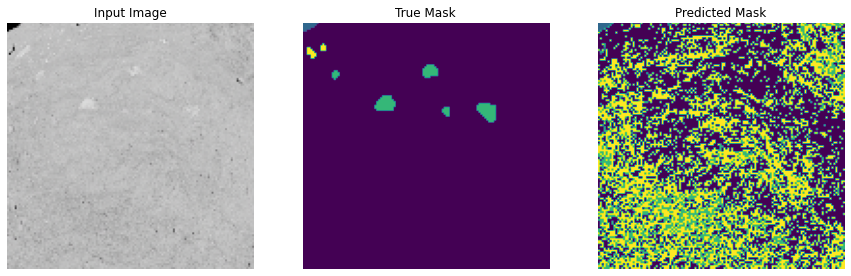

In [20]:
from skimage.metrics import adapted_rand_error
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

N_clusters = 4 # number of classes = number of clusters

def display(display_list):
  fig = plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]), vmin=0, vmax=3)
    plt.axis('off')
  plt.show()

index = np.random.randint(0,Xtest.shape[0])
print(index)
#modify the data to be the proper shape for K-Means clustering
sample_point = Xtest[index,:,:,0]
sample_label = Ytest[index,:,:,0]
sample_label = sample_label.astype(int)
sample_point = np.squeeze(sample_point)
sample_point = sample_point.reshape((sample_point.shape[0]* sample_point.shape[1],1))
Ymask = KMeans(N_clusters, init='k-means++', random_state = 0).fit(sample_point) # Kmeans cluster prediction
Yhat_mask = Ymask.labels_.reshape(Xtest.shape[1], Xtest.shape[2])
#Yhat_mask = AssignLabels(Yhat_mask, Xtest[index,:,:,0])
display([Xtest[index,:,:,:], sample_label, Yhat_mask])

Visualizing Some Outputs Mean Shift

422
[0 1 2]


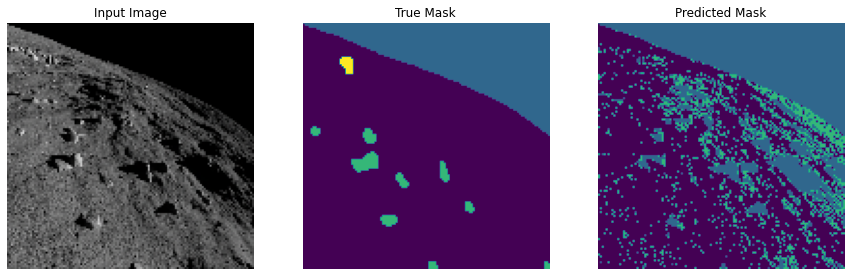

In [28]:
def display(display_list):
  fig = plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]), vmin=0, vmax=3)
    plt.axis('off')
  plt.show()


from sklearn.cluster import estimate_bandwidth
index = np.random.randint(0,Xtest.shape[0])
print(index)
#modify the data to be the proper shape for K-Means clustering
sample_point = Xtest[index,:,:,0]
sample_label = Ytest[index,:,:,0]
sample_label = sample_label.astype(int)
sample_point = sample_point.reshape((sample_point.shape[0]* sample_point.shape[1],1))


bandwidth = estimate_bandwidth(sample_point)
MeanShiftCluster = MeanShift(bandwidth = bandwidth).fit(sample_point) #Mean Shift algorithm
Yhat_maskMeanShift = MeanShiftCluster.labels_.reshape(Xtest.shape[1], Xtest.shape[2])

print(np.unique(Yhat_maskMeanShift))
display([Xtest[index,:,:,:], sample_label, Yhat_maskMeanShift])